<a href="https://colab.research.google.com/github/tfHasi/Paw-CNN-Classifer/blob/main/notebooks%5CDog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##### Problem defintion - Use computer vision to classify photos of dogs into different dog breeds.
#####Data - 20,000+ images of dogs from 120 different dog breeds from the Stanford Dogs dataset.
##### Modelling - We're going to use a pretrained convolutional neural network (CNN) and transfer learning.

In [177]:
from IPython.display import display, Image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

In [178]:
print("TF version:", tf.__version__)
# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.18.0
GPU available (YESS!!!!)


In [179]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [180]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/dog_breed_data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


IMPORTANT: Since the csv contains id with the breed type
MUST add the 'jpg' extension like below

In [181]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/dog_breed_data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:5]

['drive/My Drive/dog_breed_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog_breed_data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog_breed_data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog_breed_data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog_breed_data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [182]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/dog_breed_data/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


In [183]:
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [184]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [185]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [186]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]

###Creating our own Validation set

In [187]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since the Dataset contains 10000 images

In [188]:
# Set number of images to use for experimenting
NUM_IMAGES = 10000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

10000

In [189]:
# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

In [190]:
len(X_train), len(y_train), len(X_val), len(y_val)

(8000, 8000, 2000, 2000)

# Preprocessing

In [191]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(257, 350, 3)

In [192]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [193]:
# Define image size
IMG_SIZE = 224

def process_image_with_augmentation(image_path, augment=False):
  """
  Takes an image file path and turns it into a Tensor.
  Adds augmentation when augment=True
  """
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Apply augmentation only during training
  if augment:
    # Random flip left to right
    image = tf.image.random_flip_left_right(image)
    # Random brightness adjustment
    image = tf.image.random_brightness(image, 0.2)
    # Random contrast adjustment
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    # Random rotation (up to 20 degrees)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [194]:
# Update get_image_label to handle augmentation
def get_image_label(image_path, label, augment=False):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image_with_augmentation(image_path, augment=augment)
  return image, label

In [195]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Update create_data_batches to use augmentation
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(lambda x: process_image_with_augmentation(x, augment=False)).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(lambda x, y: get_image_label(x, y, augment=False)).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(lambda x, y: get_image_label(x, y, augment=True))

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [196]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [197]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# Visualizing Data Batches

In [198]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

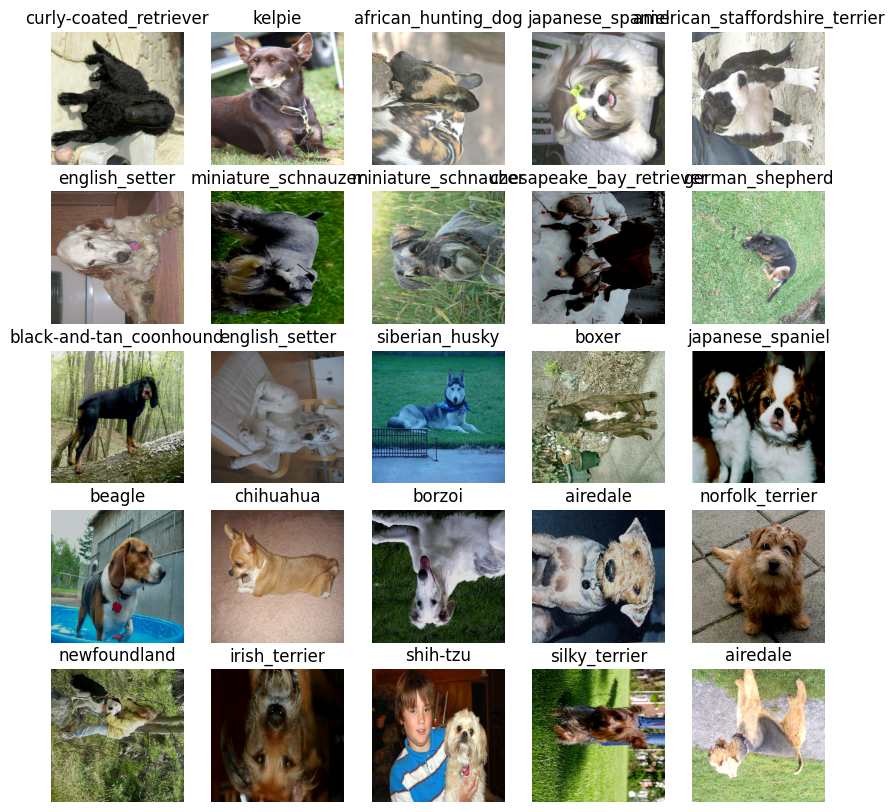

In [199]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

# Creating CallBacks

In [200]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

In [201]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 20 #@param {type:"slider", min:10, max:100, step:5}

# Create the Model

In [202]:
def create_model(input_shape=(224, 224, 3), output_shape=len(unique_breeds)):
    # Load the pre-trained MobileNetV2 model without the top classification layer
    base_model = MobileNetV2(input_shape=input_shape,
                            include_top=False,
                            weights='imagenet')

    # Freeze the base model layers
    base_model.trainable = False

    # Create a new model that goes directly from base_model to output
    inputs = base_model.input
    x = base_model.output

    x = GlobalAveragePooling2D()(x)

    # Direct connection to output
    outputs = Dense(output_shape, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [203]:
# Create the model
model = create_model(input_shape=(224, 224, 3), output_shape=len(unique_breeds))

# Print model summary
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [204]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[early_stopping])

  return model

In [205]:
# Fit the model to the data
model = train_model()

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 864ms/step - accuracy: 0.1710 - loss: 3.9034 - val_accuracy: 0.6265 - val_loss: 1.4428
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 120s 303ms/step - accuracy: 0.4788 - loss: 1.9553 - val_accuracy: 0.6840 - val_loss: 1.0940
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 311ms/step - accuracy: 0.5494 - loss: 1.6223 - val_accuracy: 0.7005 - val_loss: 1.0221
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 306ms/step - accuracy: 0.5979 - loss: 1.4785 - val_accuracy: 0.7200 - val_loss: 0.9230
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 312ms/step - accuracy: 0.6205 - loss: 1.3681 - val_accuracy: 0.7155 - val_loss: 0.9399
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 293ms/step - accuracy: 0.6489 - loss: 1.2539 - val_accuracy: 0.7230 - val_loss: 0.9233
Epoch 7/20
  1/250 ━━━━━━━━━━━━━━━━━━━━ 36:43 9s/step - accuracy: 0.7188 - loss: 1.0364

KeyboardInterrupt: 